# MNIST training and testing
This notebook contains some demos of using the GP-KAN model to perform MNIST classification

In [1]:
import sys
sys.path.append("../../") # add top-level to import path search
from lib import model as gplib
from lib import runner
from lib.dataset import MNIST

First, load the MNIST train, validation and test dataloaders

In [2]:
train_dataloader, val_dataloader, test_dataloader = MNIST.get_train_val_test(
    batch_size=64, train=50000, val=10000, test=10000
)

training on 50000
validating on 10000
testing on 10000


Load an existing model

In [3]:
model = gplib.GP_Model(saveload_path="model80k.pt")
model.print_model()

found existing saved model, loading from model80k.pt
>loaded model arch
>loaded hyp
GP_Model(
  (layer_0): GP_conv2D(
    (unfold): Unfold(kernel_size=(5, 5), dilation=(1, 1), padding=(0, 0), stride=(2, 2))
    (layerFused): LayerFused(in=25 out=4 gp_pts_per_neuron=10)
    (layerFused2): LayerFused(in=4 out=4 gp_pts_per_neuron=10)
  )
  (layer_1): NormaliseGaussian()
  (layer_2): GP_conv2D(
    (unfold): Unfold(kernel_size=(5, 5), dilation=(1, 1), padding=(0, 0), stride=(2, 2))
    (layerFused): LayerFused(in=100 out=12 gp_pts_per_neuron=10)
    (layerFused2): LayerFused(in=12 out=12 gp_pts_per_neuron=10)
  )
  (layer_3): NormaliseGaussian()
  (layer_4): ReshapeGaussian()
  (layer_5): LayerFused(in=192 out=10 gp_pts_per_neuron=10)
  (layer_6): NormaliseGaussian()
  (layer_7): LayerFused(in=10 out=10 gp_pts_per_neuron=10)
)
parameter count:  80041


Test the model

In [4]:
runner.test_model(test_dataloader, model, use_gpu=True)

testing the model ...
test_negloglik -11.720129092407227 test accuracy 0.9853                     


Example MNIST images and model prediction

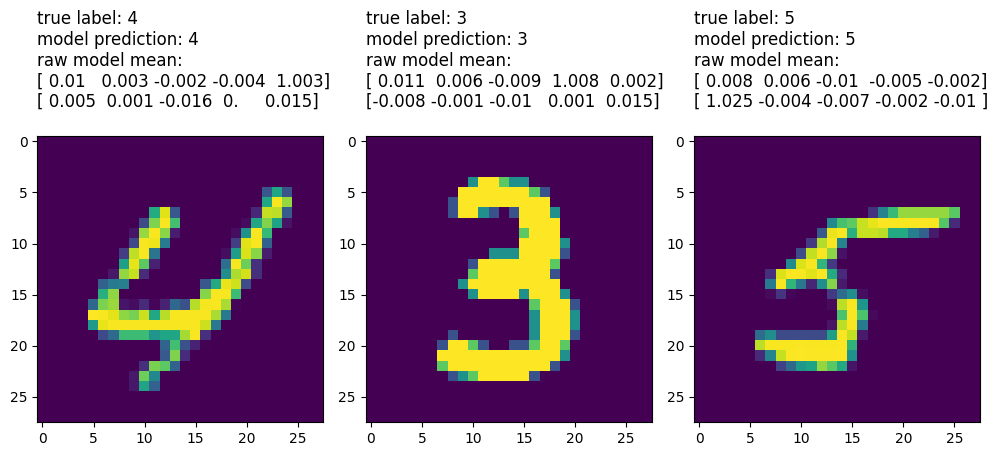

In [5]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True, precision=3)
inputs, labels = next(iter(test_dataloader))
inputs = inputs.cuda()
labels = labels.cuda()
predictions = model.predict(inputs)

fig, axes = plt.subplots(1, 3)
for i in range(3):
    axes[i].imshow(inputs[i].cpu())
    pred = predictions.mean[i].detach().cpu().numpy()
    true_label = np.argmax(labels[i].detach().cpu().numpy())
    pred_max = np.argmax(pred)
    axes[i].set_title(
        f"true label: {true_label}\n"
        f"model prediction: {pred_max}\n"
        f"raw model mean:\n{pred[:5]}\n{pred[5:]}\n",
        ha="left",
        loc="left",
    )

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()

Train a new model

In [9]:
model = gplib.GP_Model(
    [
        gplib.GP_conv2D(28, 28, 1, 3, kernel_size=4, stride=2, num_gp_pts=10, use_double_layer=True),
        gplib.NormaliseGaussian(),
        gplib.GP_conv2D(13, 13, 3, 3, kernel_size=4, stride=2, num_gp_pts=10, use_double_layer=True),
        gplib.NormaliseGaussian(),
        gplib.ReshapeGaussian([-1, 75]),
        gplib.LayerFused(75, 10, num_gp_pts=10),
        gplib.NormaliseGaussian(),
        gplib.LayerFused(10, 10, num_gp_pts=10),
    ],
    saveload_path="model.pt",
)
runner.train_model(
    train_dataloader, val_dataloader, model, epochs=20, learning_rate=1e-3, use_gpu=True, pretrain=True,
    global_jitter=1e-2, baseline_jitter=1e-2
)
model.save_model() # optionally save the model after training

  pretrain 0: internal loglik 189281.2500
  pretrain 1: internal loglik 8380.1758
  pretrain 2: internal loglik 4371.2583
  pretrain 3: internal loglik 3850.3926
  pretrain 4: internal loglik 3728.8005
  pretrain 5: internal loglik 3670.6650
  pretrain 6: internal loglik 3620.9482
  pretrain 7: internal loglik 3561.0481
  pretrain 8: internal loglik 3500.1162
  pretrain 9: internal loglik 3444.4753
epoch 0  , train negloglik: 7.01747,    val negloglik: 4.82061    accuracy: 0.1004 lr: [0.001]
epoch 1  , train negloglik: 4.03416,    val negloglik: 3.52415    accuracy: 0.1343 lr: [0.0009000000000000001]
epoch 2  , train negloglik: 3.19304,    val negloglik: 2.90022    accuracy: 0.3568 lr: [0.0009000000000000001]
epoch 3  , train negloglik: 2.60612,    val negloglik: 2.33906    accuracy: 0.5111 lr: [0.0009000000000000001]
epoch 4  , train negloglik: 2.22408,    val negloglik: 1.89831    accuracy: 0.6408 lr: [0.0009000000000000001]
epoch 5  , train negloglik: 1.95807,    val negloglik: 1.71